## **Importing all the required libraries**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("Libraries are successfully Imported")

Libraries are successfully Imported


## **Loading the dataset**

In [2]:
try:
    file_path='/content/drive/MyDrive/Dataset for ml project/merged_vaers_covid19.csv'
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully!")
    print("Dataset shape:", df.shape)
    print("\nFirst 5 rows of your data:")
    display(df.head())
except FileNotFoundError:
    print(f"ERROR: File not found at '{file_path}'.")
    print("Please make sure you have uploaded the file and the name matches exactly.")

Dataset loaded successfully!
Dataset shape: (8175, 18)

First 5 rows of your data:


,VAERS_ID,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,ORDER_x,SYMPTOM1,SYMPTOMVERSION1,SYMPTOM2,SYMPTOMVERSION2,SYMPTOM3,SYMPTOMVERSION3,SYMPTOM4,SYMPTOMVERSION4,SYMPTOM5,SYMPTOMVERSION5,ORDER_y
0,904260.0,PFIZER\BIONTECH,NaN,1,NaN,NaN,3.0,Allergic reaction to excipient,27.1,Anaphylactic reaction,27.1,Anaphylactoid reaction,27.1,NaN,NaN,NaN,NaN,3
1,1159817.0,MODERNA,017B21A,1,IM,LA,2.0,Erythema,28.0,Joint swelling,28.0,Lymphadenopathy,28.0,Pruritus,28.0,Skin warm,28.0,2
2,1289131.0,PFIZER\BIONTECH,NaN,1,NaN,NaN,6.0,COVID-19,27.1,Drug ineffective,27.1,NaN,NaN,NaN,NaN,NaN,NaN,6
3,1413779.0,MODERNA,010A21A,1,SYR,LA,2.0,Type 1 diabetes mellitus,27.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
4,1494298.0,PFIZER\BIONTECH,ew0217,1,IM,LA,2.0,Anaphylactic reaction,28.0,Angioedema,28.0,Dyspnoea,28.0,Urticaria,28.0,NaN,NaN,2


## **Defining Serious Keyword classifiers**

In [3]:
serious_keywords = ['Anaphylactic reaction', 'Dyspnoea', 'COVID-19']

# Create a new column 'IS_SERIOUS'. It will be 1 (True) if a serious symptom is found, else 0 (False).
symptom_cols = ['SYMPTOM1', 'SYMPTOM2', 'SYMPTOM3', 'SYMPTOM4', 'SYMPTOM5']

# Fill any missing symptom values with a placeholder to avoid errors
df[symptom_cols] = df[symptom_cols].fillna('None')

df['IS_SERIOUS'] = df[symptom_cols].apply(
    lambda row: 1 if any(keyword in s for s in row for keyword in serious_keywords) else 0,
    axis=1
)
print("\nCreated the target variable 'IS_SERIOUS'.")
print("Value counts for our target variable:")
print(df['IS_SERIOUS'].value_counts())


Created the target variable 'IS_SERIOUS'.
Value counts for our target variable:
IS_SERIOUS
0    7141
1    1034
Name: count, dtype: int64


In [4]:
# Select the features we think will be predictive
features = ['VAX_MANU', 'VAX_DOSE_SERIES', 'VAX_ROUTE', 'VAX_SITE']
target = 'IS_SERIOUS'

# Create our feature matrix X and target vector y
X = df[features].copy() # Use .copy() to avoid SettingWithCopyWarning
y = df[target]



# Clean the VAX_DOSE_SERIES column specifically
# pd.to_numeric will try to convert all values to numbers.
# The 'coerce' argument tells it to replace any value it can't convert (like 'UNK') with NaN.
X['VAX_DOSE_SERIES'] = pd.to_numeric(X['VAX_DOSE_SERIES'], errors='coerce')

# Now, fill any NaN values (including the ones we just created) with the mode (most frequent value)
# We do this for all numeric and object columns to be safe.
for col in X.columns:
    if X[col].isnull().any():
        mode_val = X[col].mode()[0]
        X[col] = X[col].fillna(mode_val)
        print(f"Filled missing values in '{col}' with mode: {mode_val}")



# Convert categorical features into a numerical format using one-hot encoding
X = pd.get_dummies(X, columns=['VAX_MANU', 'VAX_ROUTE', 'VAX_SITE'], drop_first=True)

print("\nProcessed features (X) are ready for the model:")
display(X.head())

Filled missing values in 'VAX_DOSE_SERIES' with mode: 1.0
Filled missing values in 'VAX_ROUTE' with mode: IM
Filled missing values in 'VAX_SITE' with mode: LA

Processed features (X) are ready for the model:


,VAX_DOSE_SERIES,VAX_MANU_MODERNA,VAX_MANU_NOVAVAX,VAX_MANU_PFIZER\BIONTECH,VAX_MANU_UNKNOWN MANUFACTURER,VAX_ROUTE_IM,VAX_ROUTE_IN,VAX_ROUTE_JET,VAX_ROUTE_OT,VAX_ROUTE_SC,VAX_ROUTE_SYR,VAX_ROUTE_UN,VAX_SITE_LA,VAX_SITE_LG,VAX_SITE_LL,VAX_SITE_NS,VAX_SITE_OT,VAX_SITE_RA,VAX_SITE_RL,VAX_SITE_UN
0,1.0,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,1.0,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False
2,1.0,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False
3,1.0,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False
4,1.0,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,    # 20% for testing
    random_state=42,  # for reproducible results
    stratify=y        # Ensures train/test sets have similar proportions of serious/non-serious cases
)

print(f"\nData split into training ({X_train.shape[0]} rows) and testing ({X_test.shape[0]} rows) sets.")




Data split into training (6540 rows) and testing (1635 rows) sets.


In [6]:
import joblib

# Get the list of all column names from your training data
model_columns = list(X_train.columns)

# Save this list to a file
joblib.dump(model_columns, 'model_columns.joblib')

print("Model columns saved to model_columns.joblib")

Model columns saved to model_columns.joblib


In [7]:

# Initialize the classifier
# n_estimators = number of trees in the forest
# random_state for reproducibility
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

print("\nTraining the Random Forest model... This might take a moment.")

# Train the model on the training data
rf_model.fit(X_train, y_train)

print("Model training complete")


Training the Random Forest model... This might take a moment.
Model training complete



Evaluating model performance on the unseen test data...

Model Accuracy: 62.14%

Classification Report:
                 precision    recall  f1-score   support

Non-Serious (0)       0.92      0.62      0.74      1428
    Serious (1)       0.19      0.62      0.29       207

       accuracy                           0.62      1635
      macro avg       0.55      0.62      0.52      1635
   weighted avg       0.83      0.62      0.68      1635

Confusion Matrix:


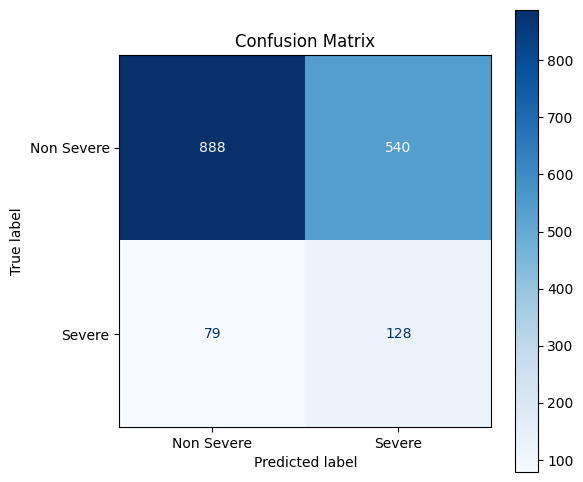

In [8]:
print("\nEvaluating model performance on the unseen test data...")

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.2%}")

# Print a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Serious (0)', 'Serious (1)']))

# Display a confusion matrix to see where the model made errors
print("Confusion Matrix:")
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test,
                                      display_labels=['Non Severe', 'Severe'],
                                      cmap='Blues',
                                      ax=ax)
plt.title("Confusion Matrix")
plt.show()

Generating advanced model visualizations... 📈


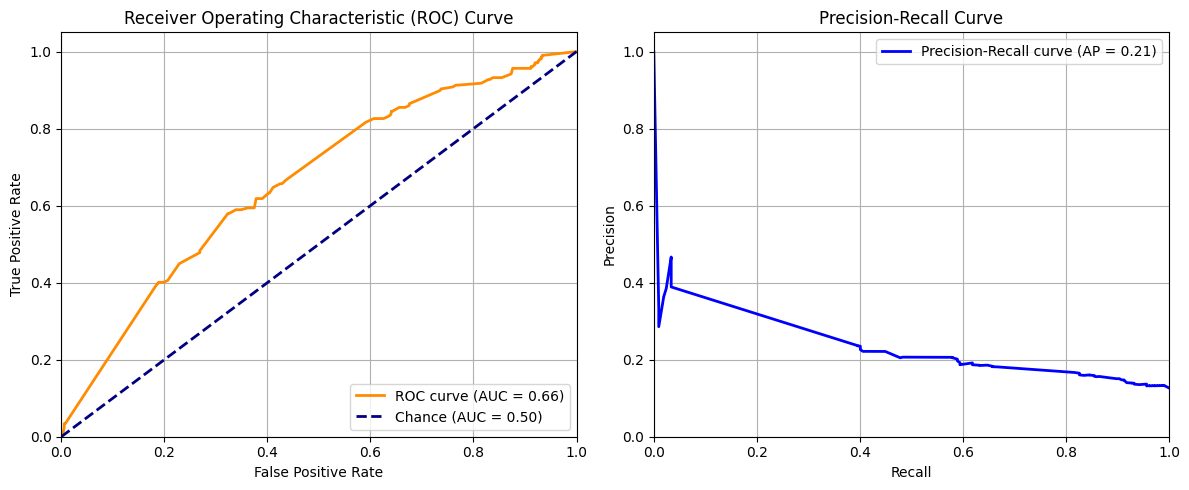

In [9]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

print("Generating advanced model visualizations... 📈")

# --- First, we need the probability predictions for the 'Serious' class ---
# The model.predict() gives a hard 0 or 1.
# We need model.predict_proba() which gives the probability for each class.
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# --- 1. ROC Curve (Receiver Operating Characteristic) ---
# It shows how well the model can distinguish between the two classes.
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 5))

# Plot ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)


# --- 2. Precision-Recall Curve ---
# This is especially useful for imbalanced datasets.
# It shows the trade-off between precision and recall for different thresholds.
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

# Plot Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
plt.grid(True)

plt.tight_layout() # Adjusts plot parameters for a tight layout
plt.show()

In [10]:
import joblib

# Assuming 'rf_model' is your trained Random Forest model
# You can do the same for your xgb_model if you have one
joblib.dump(rf_model, 'vaccine_risk_model.joblib')

print("Model saved as vaccine_risk_model.joblib")

Model saved as vaccine_risk_model.joblib


In [12]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)

# square root to get RMSE
rmse = np.sqrt(mse)

print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

Root Mean Square Error (RMSE): 0.6153
